# Image Classification and Quantization with TensorFlow/TFLite
In this turorial, we will demonstrate:
1. How to train an image classification model with Keras and TFLite model maker
2. What are different types of quantization and how to quantize our models using TensorFlow

## 1. Building a Image Classifier


### 1.1 TFLite Model Maker

The TensorFlow Lite Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications. 

The following guide is excerpted from [Tensorflow's official guide](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification) and shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers.

#### 1.1.1 Prerequisites
First, we need to prepare our work environment and install the necessary Python packages.



In [ ]:
pip install -q tflite-model-maker

     |████████████████████████████████| 616 kB 8.8 MB/s 
     |████████████████████████████████| 237 kB 46.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
     |████████████████████████████████| 120 kB 51.7 MB/s 
     |████████████████████████████████| 87 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.2 MB/s 
     |████████████████████████████████| 6.4 MB 26.9 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 50.1 MB/s 
     |████████████████████████████████| 840 kB 37.0 MB/s 
     |████████████████████████████████| 3.4 MB 37.4 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 47.8 MB 2.2 MB/s 
     |████████████████████████████████| 352 kB 34.7 MB/s 
     |████████████████████████████████| 99 kB 4.9 MB/s 
     |████████████████████████████████| 462 kB 41.8 MB/s 
     |███████████████

Next, import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

Here, we declare some global constants which will be used later

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
NUM_CLASSES = 102
BATCH_SIZE = 64

#### 1.1.2 Prepare Datasets

In this Demo, we are going to use the [oxford_flowers102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) dataset. It contains 102 common flower categrories commonly found in the UK.

We are splitting our dataset into Train, Validation and Test datasets.

*   **Training dataset** is used by our classifier during the training process in order to tune its weights so that it could learn to establish the connection between the patterns and labels
*   **Validation dataset** is also used during the training stage to constantly evaluates our model's performance on datasets that do not participate in backpropagation. It helps us to identify whether our model is overfitting our training dataset
*   **Test dataset** is used after training to assess our models generalizablity on unseen data

(Note: We are swapping train and test dataset for oxford_flowers102 due to this issue: https://github.com/tensorflow/datasets/issues/3022. After swapping, we have 6149 training images and 1020 test and validation images)



In [ ]:
test_data, val_data, train_data = DataLoader.from_tfds('oxford_flowers102')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete70OJBD/oxford_flowers102-train.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete70OJBD/oxford_flowers102-test.tfrecord


  0%|          | 0/6149 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete70OJBD/oxford_flowers102-validation.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
_, ds_info = tfds.load('oxford_flowers102', with_info=True)

In [ ]:
# let's try print out dataset descriptions
print(ds_info.description)

The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).


Let's take a glance at sample images for each class. Oftentimes, understanding the training dataset helps us to assess the difficulties of our task and adjust hyper-parameters accordingly, e.g:
1. Is the dataset balanced?
2. Should we penalize (downweight) certain classes because the pattern is too easy to recognize?
3. Should we award (overweight) correct predictions more between similar looking classes when it's hard to tell the difference visually even for human eyes?

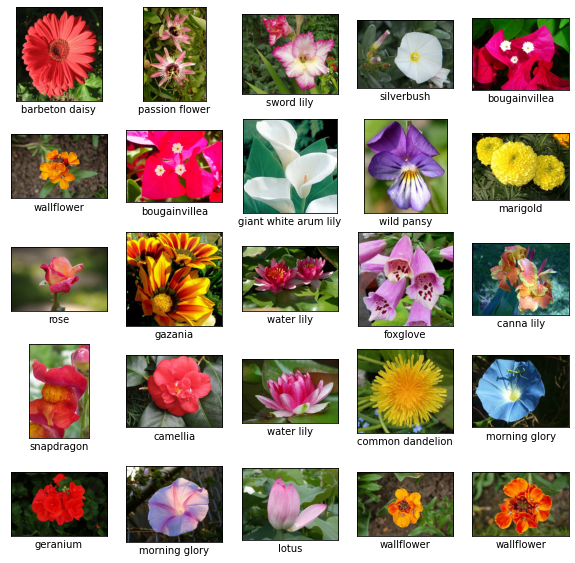

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(train_data.index_to_label[label.numpy()])
plt.show()

#### 1.1.3 Model training

Let's create an image classifier model together. The default model used by TFLite Model Maker ImageClassifier is EfficientNet-Lite0. Here, we see that we only have 130,662 trainable params out of 3.5 millions params in total, that means the weights we transferred from pre-trained backone are frozen during training. We are only updating the weights of the dense layer (our classification head) for this training process. This is called transfer-learning.


In [ ]:
tflite_model = image_classifier.create(train_data, validation_data=val_data, epochs=30, batch_size=BATCH_SIZE)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 3,543,686
Trainable params: 130,662
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


96/96 [==============================] - 52s 427ms/step - loss: 3.8377 - accuracy: 0.2406 - val_loss: 3.6709 - val_accuracy: 0.2598
Epoch 2/30
96/96 [==============================] - 40s 413ms/step - loss: 2.6904 - accuracy: 0.5560 - val_loss: 2.8880 - val_accuracy: 0.4569
Epoch 3/30
96/96 [==============================] - 40s 414ms/step - loss: 2.1592 - accuracy: 0.6960 - val_loss: 2.4134 - val_accuracy: 0.6108
Epoch 4/30
96/96 [==============================] - 40s 414ms/step - loss: 1.8742 - accuracy: 0.7834 - val_loss: 2.1170 - val_accuracy: 0.7039
Epoch 5/30
96/96 [==============================] - 40s 415ms/step - loss: 1.6955 - accuracy: 0.8340 - val_loss: 1.9208 - val_accuracy: 0.7500
Epoch 6/30
96/96 [==============================] - 40s 414ms/step - loss: 1.5736 - accuracy: 0.8651 - val_loss: 1.7867 - val_accuracy: 0.7902
Epoch 7/30
96/96 [==============================] - 40s 413ms/step - loss: 1.4913 - accuracy: 0.8903 - val_loss: 1.6890 - val_accuracy: 0.8167
Epoch 8/30

After the training is finished, it is time to evaluate our model's performnace on unseen test dataset


In [ ]:
loss, accuracy = tflite_model.evaluate(test_data)

32/32 [==============================] - 6s 176ms/step - loss: 1.2990 - accuracy: 0.9147


Not bad! Alternatively, we could also plot out our predictions on test images to visualize what are the failure cases for our model

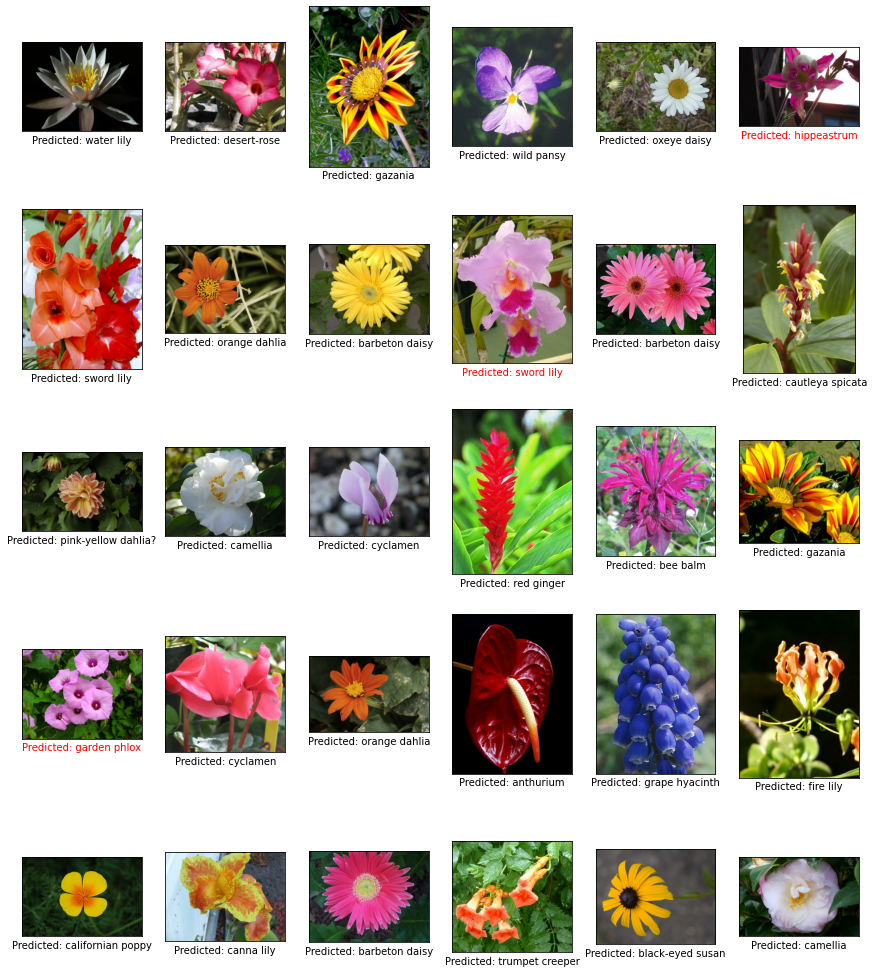

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 30 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(15, 18))
predicts = tflite_model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(30)):
  ax = plt.subplot(5, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

#### 1.1.4 Export model
Now it's time to export our model to TFLite format so that it could be imported into Lens Studio. By default, TFLite Model Maker will apply post-training quantization technique which converts the weights from float32 to int8, this helps us to make our model around 4x smaller and it can run faster on CPU and other hardware accelerators.

We will talk more about quantization in next section!

In [ ]:
tflite_model.export(export_dir='.', export_format=ExportFormat.TFLITE, tflite_filename='tflite_model_maker_flower_102_range_[0,1].tflite')

INFO:tensorflow:Assets written to: /tmp/tmp5nxn9d4l/assets


INFO:tensorflow:Assets written to: /tmp/tmp5nxn9d4l/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpeuemqdsl/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpeuemqdsl/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./tflite_model_maker_flower_102_range_[0,1].tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./tflite_model_maker_flower_102_range_[0,1].tflite


#### 1.1.5 Download model
If you are running this sample notebook on Colab, you can use the following code to download the TFLite model exported just now so that we can import it into Lens Studio. The [0,1] range specified in the name means that the model is expecting inputs normalized to values between 0 and 1. If we are reading pixel values between 0 and 255 (which our Lens Studio does), we need to set the scale to 1/255 when importing our model.

In [ ]:
from google.colab import files
files.download('tflite_model_maker_flower_102_range_[0,1].tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##1.2 Keras

tf.keras is another high-level API from Tensorflow that helps us to create and train ML models if we want to have more control in building our custom models. We can still use pre-trained weights from different backbones, but we have much more flexibility to control which layers need to be fine-tuned and what loss we want to use. In the following section, we will show how to fine-tune on a classification model pretained on imagenet to our flower classification task.

In [ ]:
def generate_dataset(split_name, batch_size):
    return tfds.load('oxford_flowers102', split=split_name, as_supervised=True, batch_size=batch_size)

# note: we are still swapping the train/test datasets here when loading so that we have more training samples
train_dataset = generate_dataset('test', BATCH_SIZE)
validation_dataset = generate_dataset('validation', BATCH_SIZE)
test_dataset = generate_dataset('train', BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
NUM_TRAIN_IMAGES = ds_info.splits['test'].num_examples

def preprocess(ds, shuffle=False, augment=False):
    # Resize and rescale input images for all datasets.
    # [0, 255] -> [-1, 1]
    ds = ds.map(lambda x, y: (tf.keras.layers.Rescaling(2./255, -1)(x), y), 
                num_parallel_calls=AUTOTUNE)
    # Images of other shapes are padded into square and resized to 224x224
    ds = ds.map(lambda x, y: (tf.image.resize_with_pad(x, IMAGE_HEIGHT, IMAGE_WIDTH), y), 
                num_parallel_calls=AUTOTUNE)

    # Shuffling is especially important on dataset where sequential images are of the same
    # class, which may easily overfit our model by only learning a single pattern
    if shuffle:
        ds = ds.shuffle(NUM_TRAIN_IMAGES, seed=123)

    # Use data augmentation only on the training set.
    # This introduces more variability into our training set, which makes our model more
    # robust to noises
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomZoom([-0.2, 0.2]),                                     
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.4),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_dataset_preprocessed = preprocess(train_dataset, shuffle=True, augment=True)
validation_dataset_preprocessed = preprocess(validation_dataset)
test_dataset_preprocessed = preprocess(test_dataset)

#### 1.2.1 Model training


This following code shows how we adapt MobileNetV2 as our backbone and transfer weights pretrained on ImageNet to our task. Note how we added data augmentation, normalization (in the dataset loading stage above) and dropout (in the model) to make our make our model more robust to noises. In this section, instead of only training the last layer, we freeze first 100 layers (where our model mostly learns to recognize edges and patterns) and let our model fine tune layers afterwards.

In [ ]:
def create_model(image_shape, num_class):
    # We use MobileNetV2 here as our backbone
    backbone = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                include_top=False,
                                                weights='imagenet')

    # Since the model is already pretrained on ImageNet and our task is fairly 
    # simple, we can reuse some of the weights and just fine tune the last few layers
    for layer in backbone.layers[:100]:
        layer.trainable = False

    # create model
    inputs = tf.keras.Input(shape=image_shape)
    x = backbone(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_class)(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
keras_model = create_model(IMG_SHAPE, NUM_CLASSES)
keras_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                

Now, it's time to compile and train our model

In [ ]:
EPOCHS = 30
# Default learning rate in TFLite model maker is 0.004
# we are using a much smaller learning rate here to fine tune our model
INITIAL_LEARNING_RATE = 0.0001
FIRST_DECAY_STEPS = len(train_dataset) * EPOCHS

def loss_fn(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(tf.one_hot(y_true, NUM_CLASSES), 
                                                    tf.expand_dims(y_pred, 1), 
                                                    from_logits=True, 
                                                    label_smoothing = 0.1)

# CosineDecay allows us to reduce our learning rate smoothly as we train more epochs 
optimizer_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(INITIAL_LEARNING_RATE, FIRST_DECAY_STEPS)

keras_model.compile(optimizer=tf.keras.optimizers.Adam(optimizer_schedule),
                    loss=loss_fn,
                    metrics=['accuracy'])

history = keras_model.fit(train_dataset_preprocessed,
                          epochs=EPOCHS,
                          validation_data=validation_dataset_preprocessed)

Epoch 1/30
97/97 [==============================] - 63s 320ms/step - loss: 3.9422 - accuracy: 0.1859 - val_loss: 3.3262 - val_accuracy: 0.3039
Epoch 2/30
97/97 [==============================] - 57s 305ms/step - loss: 2.3749 - accuracy: 0.5432 - val_loss: 2.2380 - val_accuracy: 0.5667
Epoch 3/30
97/97 [==============================] - 57s 311ms/step - loss: 1.7939 - accuracy: 0.7222 - val_loss: 1.7474 - val_accuracy: 0.7314
Epoch 4/30
97/97 [==============================] - 56s 306ms/step - loss: 1.5328 - accuracy: 0.8074 - val_loss: 1.6009 - val_accuracy: 0.7608
Epoch 5/30
97/97 [==============================] - 56s 306ms/step - loss: 1.3966 - accuracy: 0.8486 - val_loss: 1.4931 - val_accuracy: 0.8078
Epoch 6/30
97/97 [==============================] - 56s 307ms/step - loss: 1.2910 - accuracy: 0.8790 - val_loss: 1.4273 - val_accuracy: 0.8382
Epoch 7/30
97/97 [==============================] - 57s 306ms/step - loss: 1.2166 - accuracy: 0.9021 - val_loss: 1.3487 - val_accuracy: 0.8578

Plotting our training/validation losses and accuracies can help us understand whether we are underfitting our overfitting or models and adjust our learning rates and model complexities accordingly. 

In [ ]:
def plot_training_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

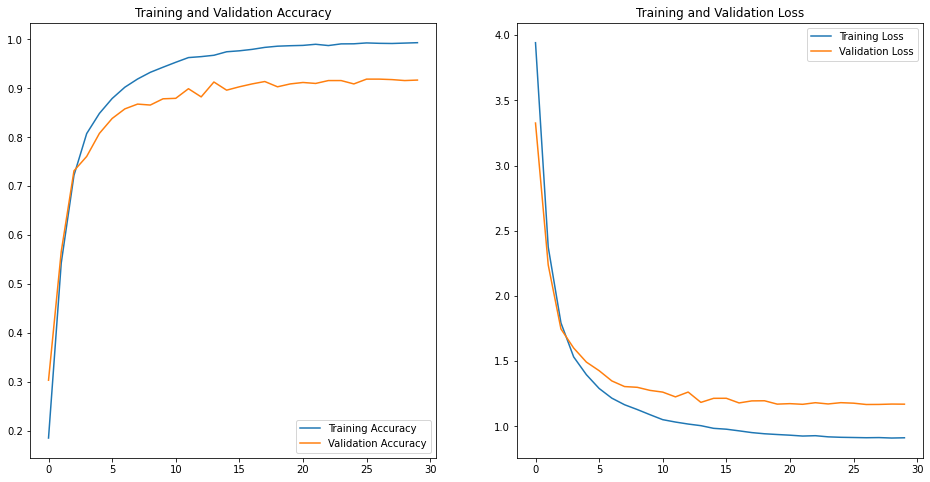

In [ ]:
plot_training_curve(history)

~ 90%, not bad, but still a little bit worse than the model we trained using TFLite model maker. Don't worry, this is because: 
1. The default architecture used in TFLite model makers is `efficientNetLite0`, which has around 3.5M parameters while the `MobileNetV2` we used only has 2.4M parameters. Larger networs often have larger capacity so that they could do more complexed tasks. However, they are running slower as well, so we need to find a balance between model accuracy, size and runtime.
2. We are using default hyper-parameters in TFLite ImageClassifier, which were carefully searched and tested to work robustly on many datasets. However, in our own Keras model, our learning rate schedules, losses, normalizations and other hyper-parameters were hand-picked, it might take many experiments or computationally expensive grid-searches to find the optimal configs.

Now, let's try to export our model, to get prediction probabilities, we need to append a softmax layer at the end of our model.


In [ ]:
def append_softmax(model):
    inputs = tf.keras.Input(shape=(224,224,3))
    x = model(inputs)
    outputs = tf.keras.activations.softmax(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
keras_model = append_softmax(keras_model)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
float_keras_model = converter.convert()
with open("./float_model_flower_102_range_[-1,1].tflite", 'wb') as f:
    f.write(float_keras_model)

INFO:tensorflow:Assets written to: /tmp/tmplbuw8oar/assets


INFO:tensorflow:Assets written to: /tmp/tmplbuw8oar/assets


#2. Quantization


##2.1 What is Quantization
Quantization for deep learning is the process of approximating a floating point (normaly 32bits) neural network with lower bit values (16bits or 8bits). This drastically reduces both the memory requirement and computational cost of the network.



##2.2 Different types of quantization

In terms of when the quantization is performed, we can categorize them into two types of quantization: 

1.   **Post-training quantization**
2.   **Quantization aware training**

And in terms of quantization specifications, we have the following choices:

*   **Per-axis** vs **per-tensor**: Per-tensor quantization means that there will be one scale and/or zero-point per entire tensor. Per-axis quantization means that there will be one scale and/or zero point per slice in the quantized dimension. 
*   **Symmetric** vs **asymmetric**: Activations are asymmetric: they can have their zero-point anywhere within the signed int8 range [-128, 127]. Weights are symmetric: forced to have zero-point equal to 0. 
*   **Signed integer** vs **unsigned integer**: TensorFlow Lite quantization will primarily prioritize tooling and kernels for int8 quantization for 8-bit. This is for the convenience of symmetric quantization being represented by zero-point equal to 0.

###2.2.1 Post Training Quantization
Post Training quantization requires a representative dataset to estimate the range, i.e, (min, max) of all floating-point tensors in the model so that we can establish a better mapping from floating point to integer space. 


In [ ]:
keras_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 102)               2388646   
                                                                 
 tf.nn.softmax (TFOpLambda)  (None, 102)               0         
                                                                 
Total params: 2,388,646
Trainable params: 1,992,102
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
def representative_dataset():
    for data, label in train_dataset_preprocessed.take(30):
        yield [np.array(data, dtype=np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
post_train_quantized_model = converter.convert()

with open("./post_train_quantized_flower_102_range_[-1,1].tflite", 'wb') as f:
    f.write(post_train_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp438jlq82/assets


INFO:tensorflow:Assets written to: /tmp/tmp438jlq82/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


###2.2.2 Quantization Aware Training

Quantization aware training simulates the lower precision behavior in the forward pass of the training process. This introduces the quantization errors as part of the training loss, which the optimizer tries to minimize during the training. Thus, QAT helps in modeling the quantization errors during training and mitigates its effects on the accuracy of the model at deployment.

In this experiment, notice that we do not freeze any layers, that means all the weights will be modified during training.

In [29]:
import tensorflow_model_optimization as tfmot
from keras import backend as K 

# quantize backbone
backbone = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
q_backbone = tfmot.quantization.keras.quantize_model(backbone)

# quantize classification head
head_model = tf.keras.models.Sequential([
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.GlobalAveragePooling2D()),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dropout(0.2)),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(NUM_CLASSES))
])
head_model.build(q_backbone.layers[-1].output_shape)
q_head = tfmot.quantization.keras.quantize_apply(head_model)

# build quantize model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = q_backbone(inputs)
outputs = q_head(x)
q_aware_model = tf.keras.Model(inputs, outputs)
q_aware_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2278138   
 ional)                                                          
                                                                 
 sequential_3 (Sequential)   (None, 102)               130674    
                                                                 
Total params: 2,408,812
Trainable params: 2,354,534
Non-trainable params: 54,278
_________________________________________________________________


In [30]:
EPOCHS = 30
INITIAL_LEARNING_RATE = 0.0001
FIRST_DECAY_STEPS = len(train_dataset) * 50

optimizer_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(INITIAL_LEARNING_RATE, FIRST_DECAY_STEPS)
q_aware_model.compile(tf.keras.optimizers.Adam(optimizer_schedule),
                      loss=loss_fn,
                      metrics=['accuracy'])

In [31]:
history = q_aware_model.fit(train_dataset_preprocessed,
                            epochs=EPOCHS,
                            validation_data=validation_dataset_preprocessed)

Epoch 1/30
97/97 [==============================] - 100s 612ms/step - loss: 3.8937 - accuracy: 0.1948 - val_loss: 4.3414 - val_accuracy: 0.0853
Epoch 2/30
97/97 [==============================] - 83s 579ms/step - loss: 2.3993 - accuracy: 0.5624 - val_loss: 3.4591 - val_accuracy: 0.2157
Epoch 3/30
97/97 [==============================] - 83s 582ms/step - loss: 1.7597 - accuracy: 0.7312 - val_loss: 2.8964 - val_accuracy: 0.3480
Epoch 4/30
97/97 [==============================] - 83s 580ms/step - loss: 1.4519 - accuracy: 0.8361 - val_loss: 2.4503 - val_accuracy: 0.4667
Epoch 5/30
97/97 [==============================] - 83s 583ms/step - loss: 1.3028 - accuracy: 0.8788 - val_loss: 2.1288 - val_accuracy: 0.5824
Epoch 6/30
97/97 [==============================] - 83s 581ms/step - loss: 1.1960 - accuracy: 0.9140 - val_loss: 2.0590 - val_accuracy: 0.6049
Epoch 7/30
97/97 [==============================] - 83s 580ms/step - loss: 1.1350 - accuracy: 0.9341 - val_loss: 1.8307 - val_accuracy: 0.680

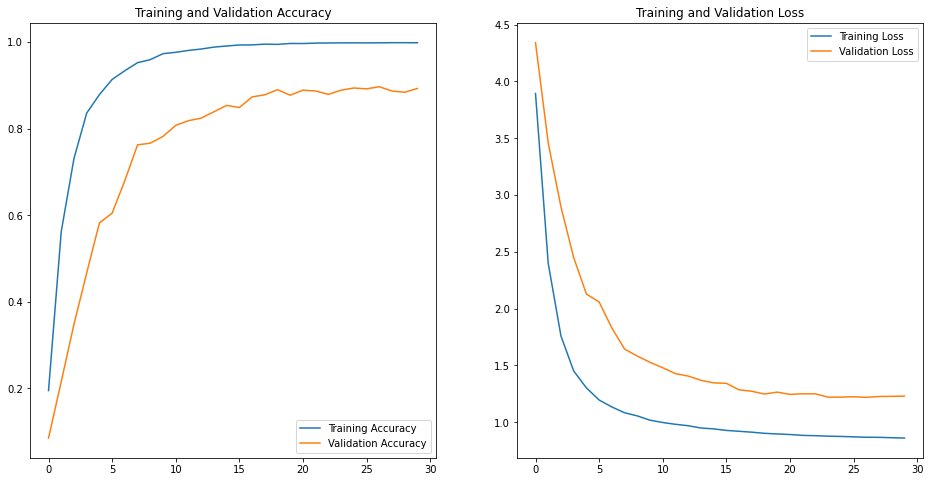

In [32]:
plot_training_curve(history)

In [33]:
q_aware_model = append_softmax(q_aware_model)
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

with open("./quantize_aware_flower_102_range_[-1,1].tflite", 'wb') as f:
    f.write(quantized_aware_model)

INFO:tensorflow:Assets written to: /tmp/tmpa7wbk5ym/assets


INFO:tensorflow:Assets written to: /tmp/tmpa7wbk5ym/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Compare models

## 3.1 Comparing accuracy

In [34]:
test_images = []
test_labels = []
for batch in list(test_dataset_preprocessed):
    test_images.append(batch[0])
    test_labels.append(batch[1])
    
test_images = np.vstack(test_images)
test_labels = np.hstack(test_labels)

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(test_images)))

In [35]:
evaluate_model('./float_model_flower_102_range_[-1,1].tflite', model_type="Float")

Float model accuracy is 87.8431% (Number of test samples=1020)


In [36]:
evaluate_model('./post_train_quantized_flower_102_range_[-1,1].tflite', model_type="Post-training Quantized")

Post-training Quantized model accuracy is 87.3529% (Number of test samples=1020)


In [37]:
evaluate_model('./quantize_aware_flower_102_range_[-1,1].tflite', model_type="Quantize-Aware Trained")

Quantize-Aware Trained model accuracy is 87.5490% (Number of test samples=1020)


We can see that both quantization measures will result in accuracy drops. But there are still some trade-offs between them:

- Post training quantization is easier to use and does not require retraining
- Quantize aware training minimizes quantization loss and often have better accuracy

## 3.1 Comparing size
Next, we can also compare size differences between float and 8 bits quantized model:

In [38]:
!ls -hl

total 19M
-rw-r--r-- 1 root root 9.0M Apr 15 23:55 'float_model_flower_102_range_[-1,1].tflite'
-rw-r--r-- 1 root root 2.8M Apr 16 00:00 'post_train_quantized_flower_102_range_[-1,1].tflite'
-rw-r--r-- 1 root root 2.8M Apr 16 01:15 'quantize_aware_flower_102_range_[-1,1].tflite'
drwxr-xr-x 1 root root 4.0K Apr  8 13:32  sample_data
-rw-r--r-- 1 root root 4.0M Apr 15 23:26 'tflite_model_maker_flower_102_range_[0,1].tflite'


We see that `float_model.tflite` is 9.0MB and `post_training_quantized_model.tflite` and `quantize_aware_model.tflite` are only 2.8MB.